
# EXPLORATORY DATA ANALYSIS (EDA)

This notebook:
- Loads **FARS** data (2015–2018)
- Performs **weather** analysis (crashes, fatalities, dark-share)
- Performs **time** analysis (hour and month)
- Performs **gender** and **age-group** analysis (from `person.csv`)
- **Displays** all plots inline **and** saves `.csv` and `.png` outputs under `EDA_visualizations/` for further usage

In [6]:

import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 50)


In [7]:
def find_project_root():
    here = Path.cwd()
    candidates = [here] + list(here.parents)
    for c in candidates:
        if (c / "data").exists():
            return c
    return here

BASE_DIR = find_project_root()
DATA_DIR = BASE_DIR / "data"
FIG_DIR = BASE_DIR / "EDA_visualizations"
FIG_DIR.mkdir(parents=True, exist_ok=True)
YEARS = [2015, 2016, 2017, 2018]

BASE_DIR, DATA_DIR, FIG_DIR


(PosixPath('/Users/patricijamarijanovic/AVEIRO/FCD/foundations-of-data-science'),
 PosixPath('/Users/patricijamarijanovic/AVEIRO/FCD/foundations-of-data-science/data'),
 PosixPath('/Users/patricijamarijanovic/AVEIRO/FCD/foundations-of-data-science/EDA_visualizations'))

In [8]:

def ensure_year_dirs(year:int):
    year_dir = FIG_DIR / str(year)
    (year_dir / "CRASHES - WEATHER").mkdir(parents=True, exist_ok=True)
    (year_dir / "TIME").mkdir(parents=True, exist_ok=True)
    (year_dir / "GENDER").mkdir(parents=True, exist_ok=True)
    (year_dir / "AGE").mkdir(parents=True, exist_ok=True)
    return {
        "year_dir": year_dir,
        "weather_dir": year_dir / "CRASHES - WEATHER",
        "time_dir": year_dir / "TIME",
        "gender_dir": year_dir / "GENDER",
        "age_dir": year_dir / "AGE",
    }

def load_year(year:int):
    year_dir = DATA_DIR / f"FARS{year}NationalCSV"
    acc_path = year_dir / "accident.csv"
    veh_path = year_dir / "vehicle.csv"
    per_path = year_dir / "person.csv"

    if not acc_path.exists():
        print(f"[!] Missing accident.csv for {year} at {acc_path}")
        return None

    accident = pd.read_csv(acc_path, low_memory=False, encoding_errors="ignore")
    veh = pd.read_csv(veh_path, low_memory=False, encoding_errors="ignore") if veh_path.exists() else None
    per = pd.read_csv(per_path, low_memory=False, encoding_errors="ignore") if per_path.exists() else None
    return {"acc": accident, "veh": veh, "per": per}


In [9]:

def eda_weather_time(data:dict, year:int):
    acc = data["acc"].copy()

    # Ensures that specific columns (like HOUR, FATALS) are treated as numbers for analysis
    for col in ["MONTH","DAY","DAY_WEEK","HOUR","MINUTE","FATALS"]:
        if col in acc:
            acc[col] = pd.to_numeric(acc[col], errors="coerce")

    # Creates a new boolean column is_dark (True if it has a word "dark")
    acc["is_dark"] = acc["LGT_CONDNAME"].astype(str).str.contains("Dark", na=False)

    # Creates the necessary output directories to save results for the specific year
    # to create folders like EDA_visualizations/2015/CRASHES - WEATHER/
    dirs = ensure_year_dirs(year)
    weather_dir, time_dir = dirs["weather_dir"], dirs["time_dir"]

    # Counts the number of crashes for each weather condition (e.g., "Rain", "Clear")
    # creates another column "crashes" with the number of crashes for a specific category
    weather_counts_raw = (
        acc.groupby("WEATHERNAME").size().rename("crashes").reset_index().sort_values("crashes", ascending=False)
    )

    # Remove unimportant groups
    unimportant = ["Unknown","Not Reported","Other"]
    weather_counts = weather_counts_raw[~weather_counts_raw["WEATHERNAME"].isin(unimportant)].copy()

    # The number of categories that were removed
    dropped_rows = len(weather_counts_raw) - len(weather_counts)
    # How many actual crashes were thrown out
    dropped_total = weather_counts_raw.loc[weather_counts_raw["WEATHERNAME"].isin(unimportant), "crashes"].sum()

    # The total number of crashes that occurred under known, reportable weather conditions
    total_crashes = weather_counts["crashes"].sum()
    # Creates a new column in the DataFrame, every row the same
    weather_counts["total_crashes"] = total_crashes
    # Calculate the Percentage for Each Row
    weather_counts["percent_of_total"] = 100 * weather_counts["crashes"] / total_crashes

    # Adds a new row at the bottom of the table that shows the TOTAL
    weather_counts = pd.concat([
        weather_counts,
        pd.DataFrame({"WEATHERNAME":["Total (excluding Unknown/Other/Not Reported)"],
                      "crashes":[total_crashes],
                      "total_crashes":[total_crashes],
                      "percent_of_total":[100.0]})], ignore_index=True)

    # How many total people died in accidents that happened in different weather conditions
    fatalities_by_weather_raw = (
        acc.groupby("WEATHERNAME")["FATALS"].sum().rename("total_fatalities").reset_index()
        .sort_values("total_fatalities", ascending=False)
    )

    # Remove unimportant groups
    fatalities_by_weather = fatalities_by_weather_raw[~fatalities_by_weather_raw["WEATHERNAME"].isin(unimportant)].copy()

    # Calculate how many people died in total
    total_fatalities = fatalities_by_weather["total_fatalities"].sum()

    # Add a new column with percentage
    fatalities_by_weather["percent_of_total"] = 100 * fatalities_by_weather["total_fatalities"] / total_fatalities

    # Adds a new row at the bottom of the table that shows the TOTAL
    fatalities_by_weather = pd.concat([
        fatalities_by_weather,
        pd.DataFrame({"WEATHERNAME":["Total (excluding Unknown/Other/Not Reported)"],
                      "total_fatalities":[total_fatalities],
                      "percent_of_total":[100.0]})], ignore_index=True)

    # We want to answer the question: "For crashes that happened in 'Fog', what share of them were at night?
    dark_share_raw = (
        acc.groupby("WEATHERNAME")["is_dark"].mean().rename("share_dark").reset_index().sort_values("share_dark", ascending=False)
    )
    dark_share = dark_share_raw[~dark_share_raw["WEATHERNAME"].isin(unimportant)].copy()
    dark_share["share_dark (%)"] = 100 * dark_share["share_dark"]
    dark_share = dark_share.drop(columns=["share_dark"])

    # How traffic crashes are distributed across the 24 hours of the day
    by_hour = (
        acc.groupby("HOUR").size().rename("crashes").reset_index().sort_values("HOUR")
    )
    by_hour = by_hour[by_hour["HOUR"] != 99]
    total_hourly = by_hour["crashes"].sum()
    by_hour["percent_of_total"] = (100 * by_hour["crashes"] / total_hourly).round(2)
    by_hour = pd.concat([by_hour, pd.DataFrame({"HOUR":["Total"], "crashes":[total_hourly], "percent_of_total":[100.0]})], ignore_index=True)

    # Counts the number of traffic crashes for each month of the year
    by_month = (
        acc.groupby(["MONTH","MONTHNAME"]).size().rename("crashes").reset_index().sort_values("MONTH")
    )

    # Saving analysis results to files so we can use them later
    weather_counts.to_csv(weather_dir / f"{year}_weather_counts.csv", index=False)
    fatalities_by_weather.to_csv(weather_dir / f"{year}_fatalities_by_weather.csv", index=False)
    dark_share.to_csv(weather_dir / f"{year}_share_dark_by_weather.csv", index=False)

    by_hour.to_csv(time_dir / f"{year}_hour_counts.csv", index=False)
    by_month.to_csv(time_dir / f"{year}_month_counts.csv", index=False)

    # Bar chart that visualizes the number of crashes for each weather condition
    plt.figure(figsize=(10,6))
    plt.bar(weather_counts["WEATHERNAME"][:-1], weather_counts["crashes"][:-1])
    plt.xticks(rotation=45, ha="right")
    plt.title(f"{year}: Crashes by Weather")
    plt.ylabel("Number of Crashes")
    plt.tight_layout()
    plt.show()
    plt.savefig(weather_dir / f"{year}_crashes_by_weather_BarChart.png")
    plt.close()

    # Pie chart to show the proportion of crashes by weather condition
    # Only the top 3 largest slices are labeled to keep the chart clean and readable
    weather_pie = weather_counts.iloc[:-1].sort_values("crashes", ascending=False).copy()
    top3 = weather_pie["WEATHERNAME"].head(3).tolist()
    def autopct_func(pct, all_vals):
        absolute = int(round(pct / 100.0 * np.sum(all_vals)))
        if absolute in weather_pie.loc[weather_pie["WEATHERNAME"].isin(top3), "crashes"].values:
            return f"{pct:.1f}%"
        return ""
    labels = [name if name in top3 else "" for name in weather_pie["WEATHERNAME"]]
    plt.figure(figsize=(7,7))
    plt.pie(weather_pie["crashes"], labels=labels, autopct=lambda pct: autopct_func(pct, weather_pie["crashes"]), startangle=90)
    plt.title(f"{year}: Crashes by Weather (Only Top 3 Labeled)")
    plt.tight_layout()
    plt.show()
    plt.savefig(weather_dir / f"{year}_crashes_by_weather_PieChart.png")
    plt.close()

    # Bar chart that visualizes the total number of fatalities (deaths) for each weather condition
    fatalities_plot = fatalities_by_weather[~fatalities_by_weather["WEATHERNAME"].str.contains("Total", case=False, na=False)]
    plt.figure(figsize=(10,6))
    plt.bar(fatalities_plot["WEATHERNAME"], fatalities_plot["total_fatalities"])
    plt.xticks(rotation=45, ha="right")
    plt.title(f"{year}: Total Fatalities by Weather Condition")
    plt.ylabel("Total Fatalities")
    plt.tight_layout()
    plt.show()
    plt.savefig(weather_dir / f"{year}_fatalities_by_weather_BarChart.png")
    plt.close()

    # Bar chart that shows the top 10 weather conditions with the highest percentage of crashes occurring in the dark
    top_dark = dark_share.sort_values("share_dark (%)", ascending=False).head(10)
    plt.figure(figsize=(10,6))
    plt.bar(top_dark["WEATHERNAME"], top_dark["share_dark (%)"])
    plt.xticks(rotation=45, ha="right")
    plt.title(f"{year}: Share of Crashes in Dark Conditions by Weather (Top 10)")
    plt.ylabel("Share of Crashes in Dark Conditions (%)")
    plt.tight_layout()
    plt.show()
    plt.savefig(weather_dir / f"{year}_dark_share_by_weather.png")
    plt.close()

    # Line plot that visualizes how the number of traffic crashes changes throughout the 24 hours of a day
    by_hour_plot = by_hour[by_hour["HOUR"] != "Total"].copy()
    plt.figure()
    plt.plot(by_hour_plot["HOUR"], by_hour_plot["crashes"], marker="o")
    plt.title(f"{year}: Crashes by Hour of Day")
    plt.xlabel("Hour")
    plt.ylabel("Crashes")
    plt.xticks(np.arange(0, 24, 3))
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()
    plt.savefig(time_dir / f"{year}_crashes_by_hour.png")
    plt.close()

    # Bar chart that shows the number of traffic crashes for each month of the year
    plt.figure()
    plt.bar(by_month["MONTHNAME"], by_month["crashes"], color="red")
    plt.xticks(rotation=45, ha="right")
    plt.title(f"{year}: Crashes by Month")
    plt.tight_layout()
    plt.show()
    plt.savefig(time_dir / f"{year}_crashes_by_month.png")
    plt.close()

    # Find Top 3 Weather Conditions by Number of Crashes
    top_weather = weather_counts.iloc[:-1].sort_values("crashes", ascending=False).head(3)
    # Find Top 3 Weather Conditions by Number of Fatalities
    top_fatal_weather = fatalities_plot.sort_values("total_fatalities", ascending=False).head(3)

    return {
        "year": year,
        "total_crashes": int(total_crashes),
        "dropped_weather_rows": int(dropped_rows),
        "dropped_weather_crashes": int(dropped_total),
        "top_weather": top_weather[["WEATHERNAME","crashes"]].to_dict(orient="records"),
        "top_fatal_weather": top_fatal_weather[["WEATHERNAME","total_fatalities"]].to_dict(orient="records"),
        "peak_hour": int(by_hour_plot.loc[by_hour_plot['crashes'].idxmax(), 'HOUR']) if not by_hour_plot.empty else None,
        "peak_month": str(by_month.loc[by_month['crashes'].idxmax(), 'MONTHNAME']) if not by_month.empty else None,
    }


In [10]:

def eda_person(data:dict, year:int):
    per = data.get("per")
    if per is None or per.empty:
        print(f"[!] No person.csv for {year}; skipping gender/age.")
        return {"year":year, "gender_top":[], "age_peak":None}

    for col in ["AGE","SEX"]:
        if col in per:
            per[col] = pd.to_numeric(per[col], errors="coerce")

    dirs = ensure_year_dirs(year)
    gender_dir, age_dir = dirs["gender_dir"], dirs["age_dir"]

    out = {"year":year}

    if "SEXNAME" in per:
        gender_counts = (
            per.groupby("SEXNAME").size().rename("people_involved").reset_index().sort_values("people_involved", ascending=False)
        )
        unimportant = ["Unknown","Not Reported","Other"]
        gender_counts = gender_counts[~gender_counts["SEXNAME"].isin(unimportant)]
        total_people = gender_counts["people_involved"].sum()
        gender_counts["percent_of_total"] = 100 * gender_counts["people_involved"] / total_people
        gender_counts = pd.concat([
            gender_counts,
            pd.DataFrame({"SEXNAME":["Total (excluding Unknown/Other/Not Reported)"],
                          "people_involved":[total_people],
                          "percent_of_total":[100.0]})], ignore_index=True)

        gender_counts.to_csv(gender_dir / f"{year}_gender_counts.csv", index=False)

        plt.figure(figsize=(8,6))
        color_map = {"Male":"royalblue", "Female":"hotpink"}
        colors = [color_map.get(name, "gray") for name in gender_counts["SEXNAME"][:-1]]
        plt.bar(gender_counts["SEXNAME"][:-1], gender_counts["people_involved"][:-1], color=colors)
        plt.title(f"{year}: People Involved in Accidents by Gender")
        plt.ylabel("Number of People")
        plt.xlabel("Gender")
        plt.tight_layout()
        plt.show()
        plt.savefig(gender_dir / f"{year}_gender_bar_chart.png")
        plt.close()

        out["gender_top"] = gender_counts.iloc[:-1].sort_values("people_involved", ascending=False).head(2).to_dict(orient="records")
    else:
        out["gender_top"] = []

    if "AGE" in per:
        age_filtered = per[(per["AGE"] >= 0) & (per["AGE"] <= 120)].copy()
        bins = list(range(0, 90, 10)) + [200]
        labels = [f"{b}-{b+9}" for b in range(0, 80, 10)] + ["80+"]
        age_filtered["AGE_GROUP"] = pd.cut(age_filtered["AGE"], bins=bins, labels=labels, right=False)

        age_counts = (
            age_filtered.groupby("AGE_GROUP", observed=True).size().rename("people_involved").reset_index().sort_values("AGE_GROUP")
        )
        total_age_people = age_counts["people_involved"].sum()
        age_counts["percent_of_total"] = 100 * age_counts["people_involved"] / total_age_people
        age_counts = pd.concat([
            age_counts,
            pd.DataFrame({"AGE_GROUP":["Total"], "people_involved":[total_age_people], "percent_of_total":[100.0]})], ignore_index=True)

        age_counts.to_csv(age_dir / f"{year}_age_counts.csv", index=False)

        plt.figure(figsize=(10,6))
        plt.bar(age_counts["AGE_GROUP"][:-1], age_counts["people_involved"][:-1], color="orange")
        plt.title(f"{year}: People Involved in Accidents by Age Group")
        plt.ylabel("Number of People")
        plt.xlabel("Age Group")
        plt.tight_layout()
        plt.show()
        plt.savefig(age_dir / f"{year}_age_bar_chart.png")
        plt.close()

        peak_age_group = str(age_counts.iloc[:-1].sort_values("people_involved", ascending=False).iloc[0]["AGE_GROUP"])
        out["age_peak"] = peak_age_group
    else:
        out["age_peak"] = None

    return out


## Run full EDA (2015–2018) and show/save outputs


[>] Running EDA for 2015


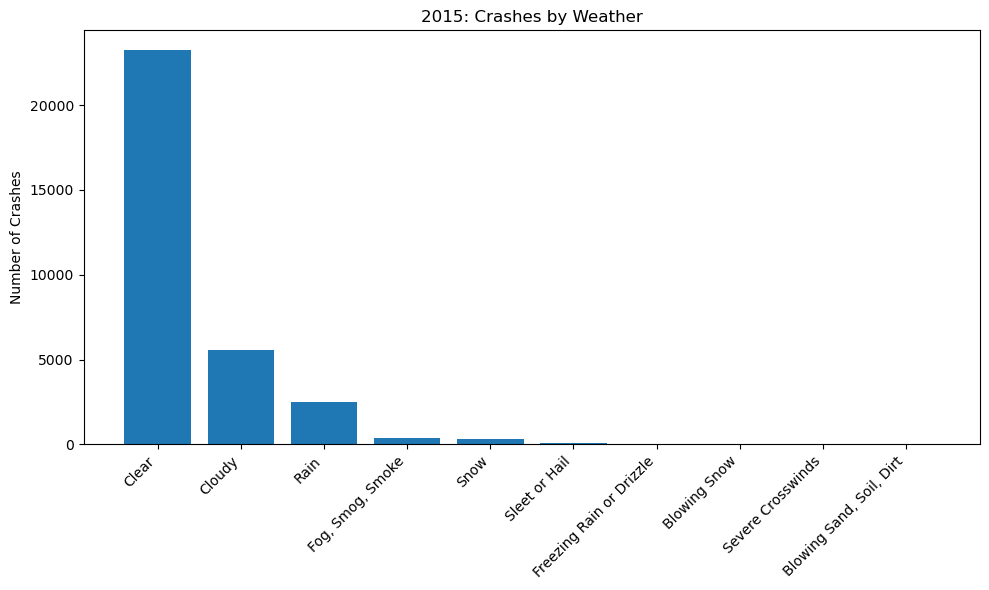

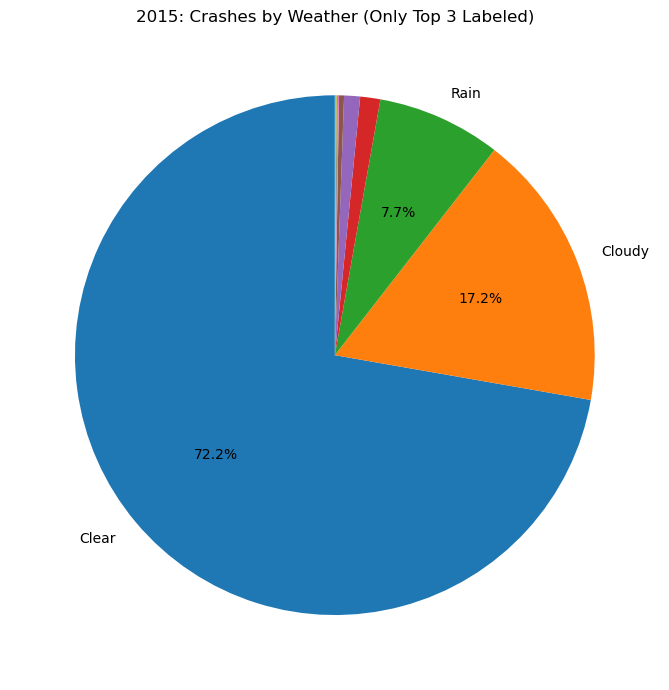

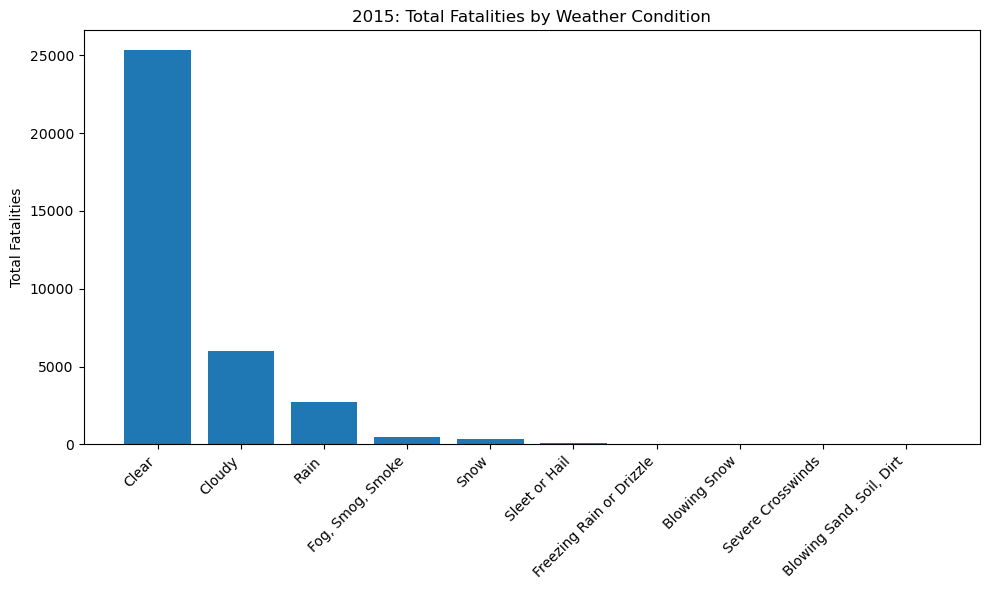

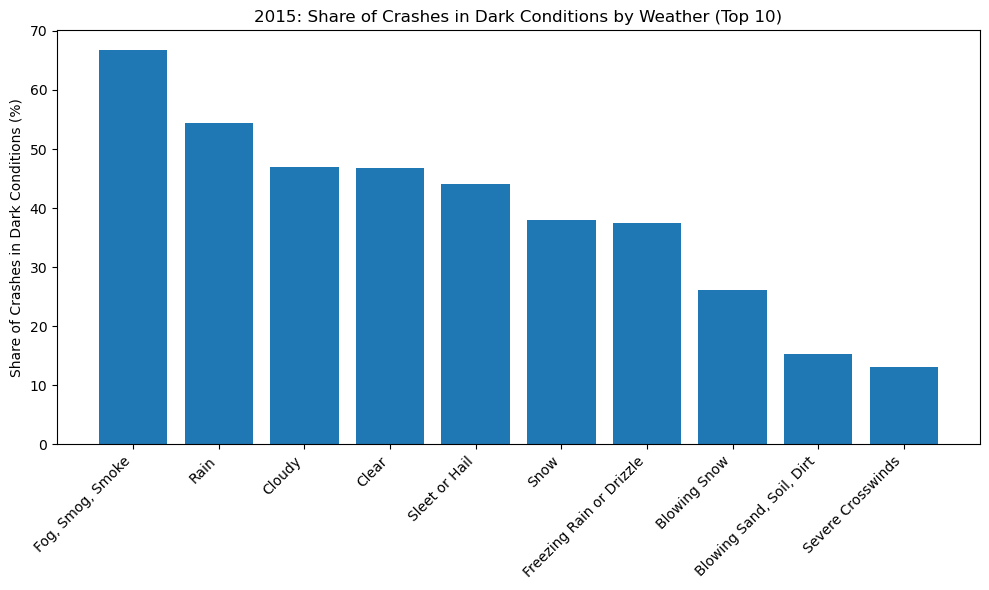

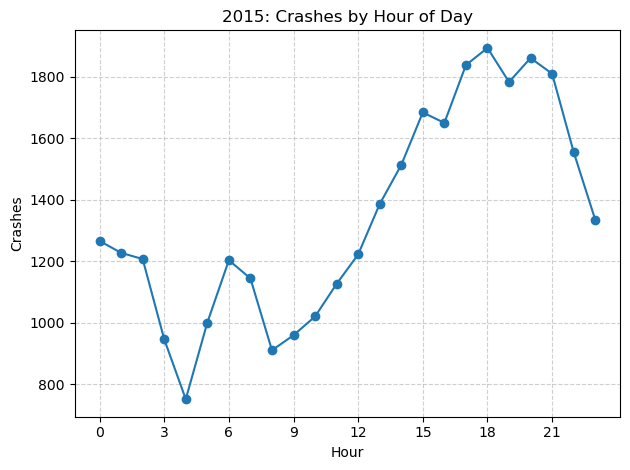

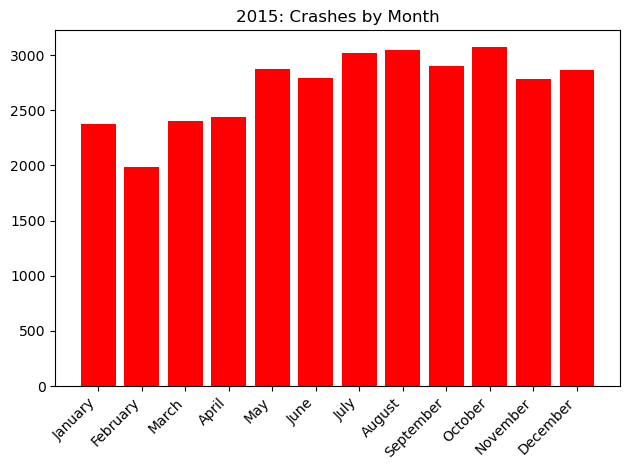

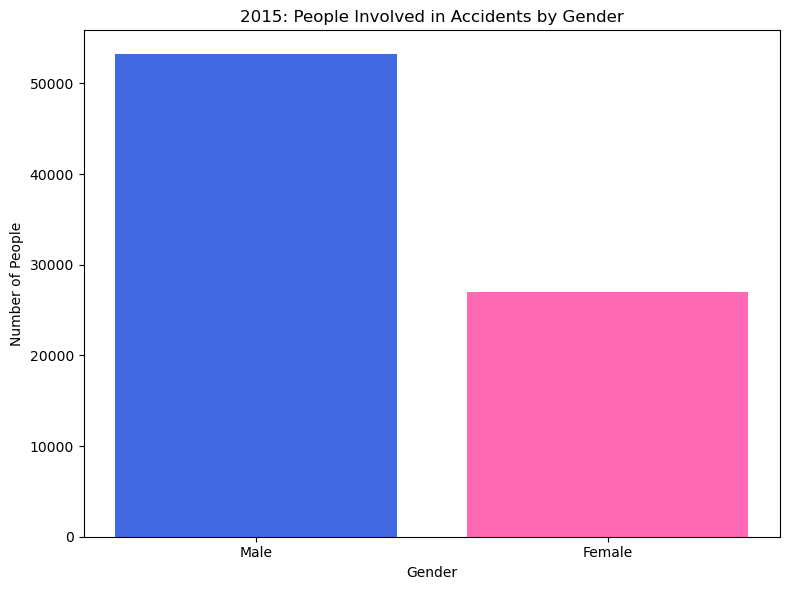

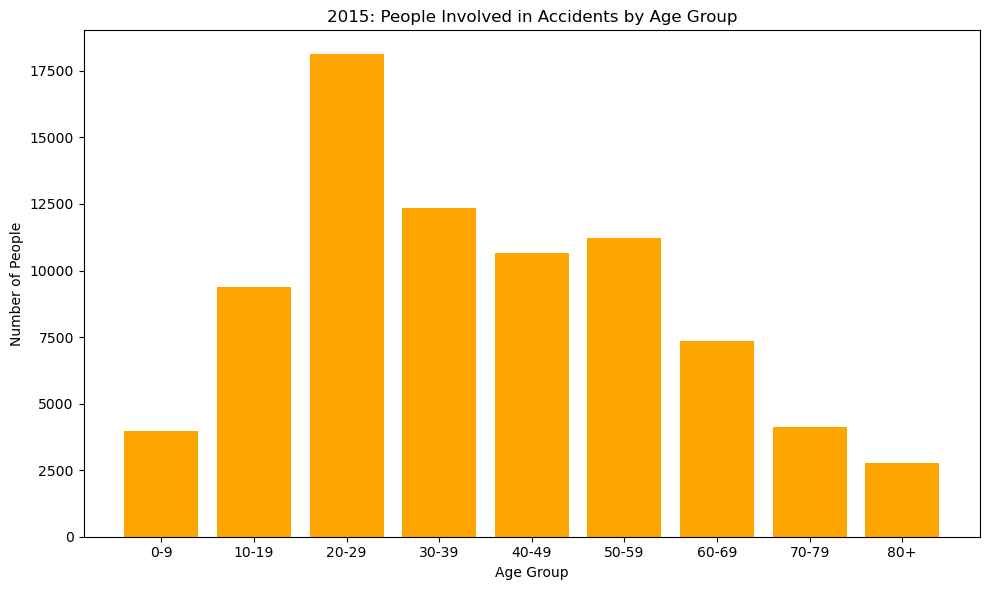

[Year 2015] Total crashes (cleaned): 32,174
  - Most common weather: Clear (23,243 crashes)
  - Highest fatalities weather: Clear (25,337 fatalities)
  - Peak crash hour: 18:00
  - Peak crash month: October
  - Gender distribution top: Male (53,199)
  - Peak age group: 20-29

[>] Running EDA for 2016


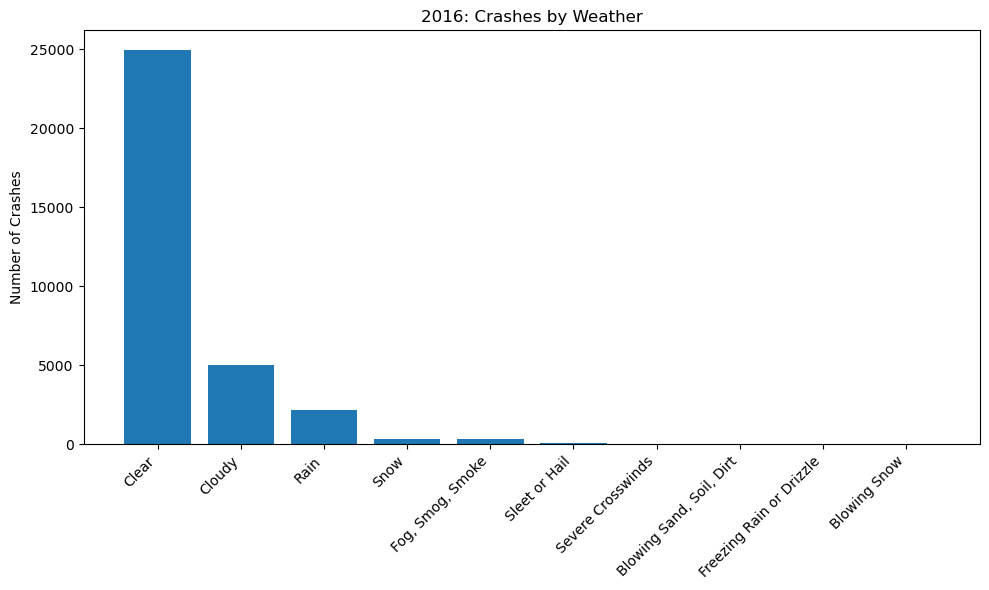

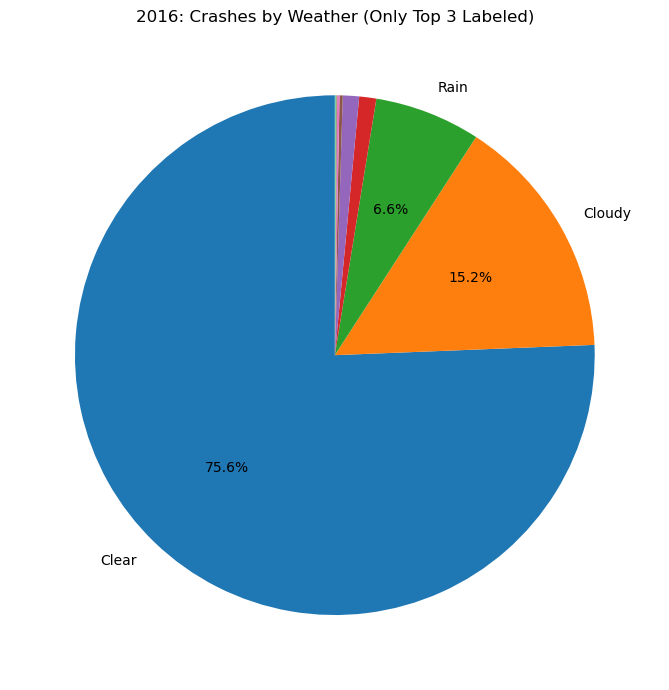

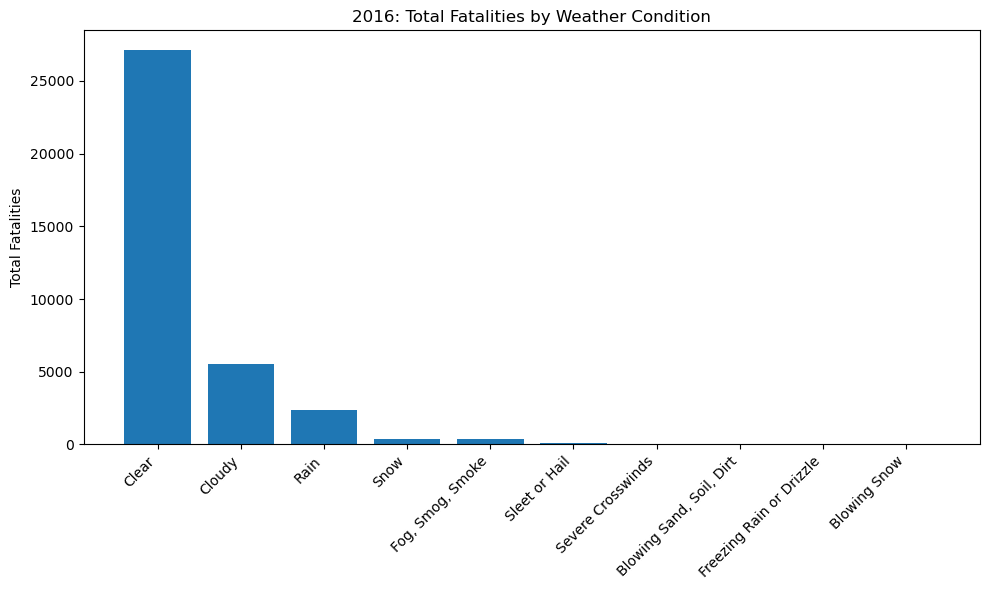

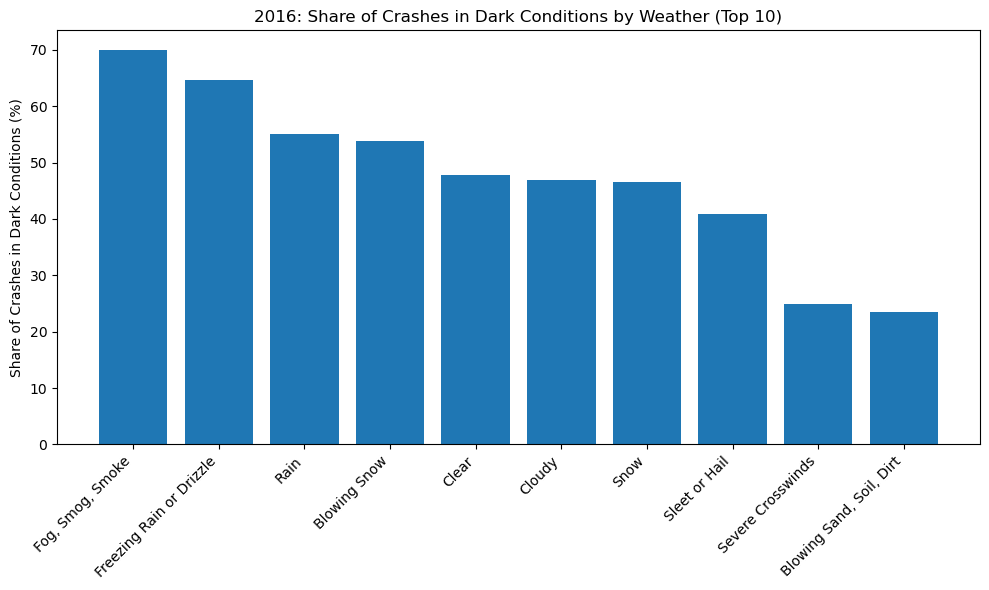

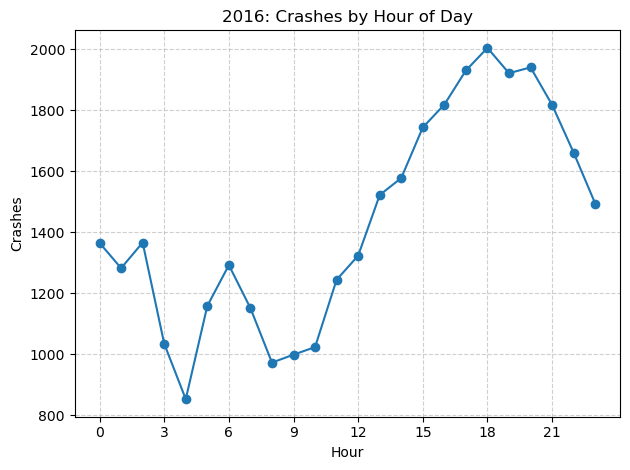

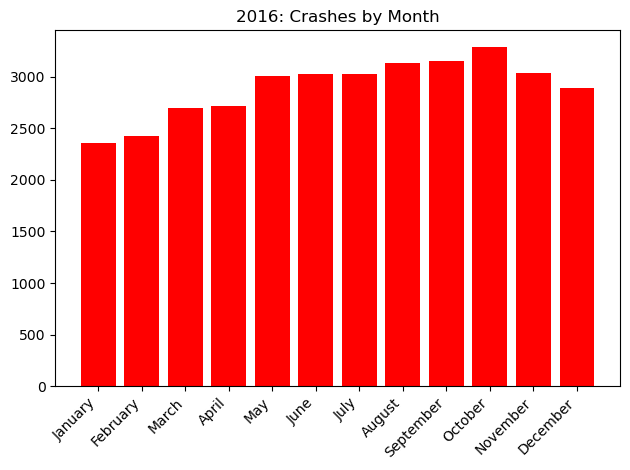

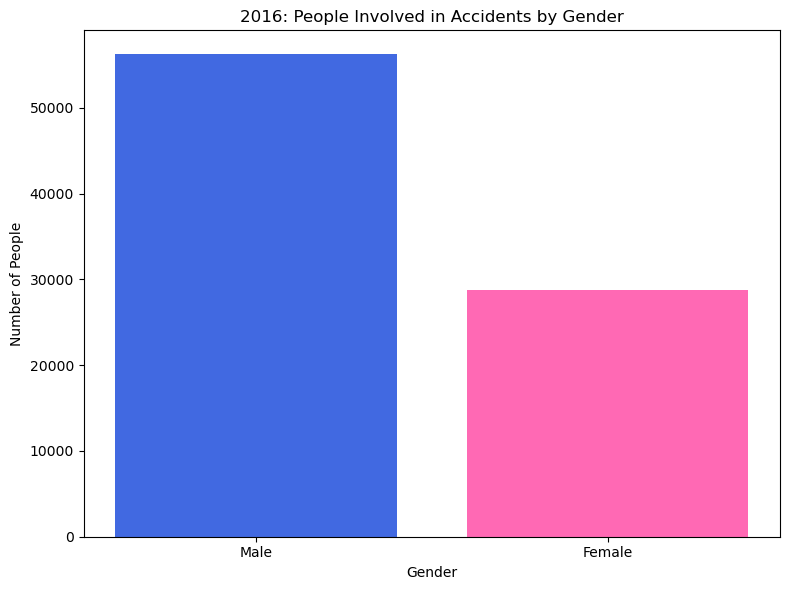

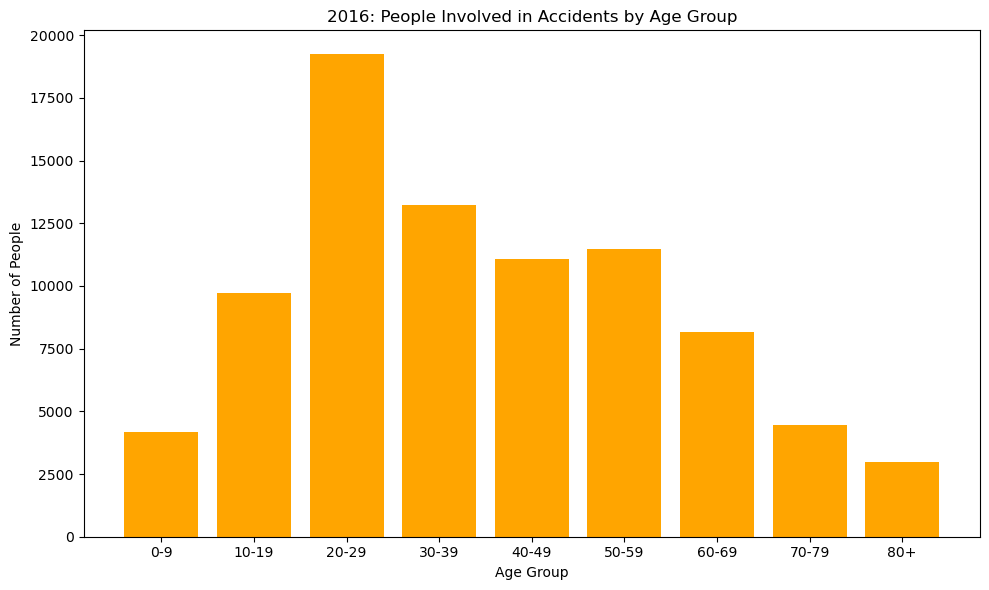

[Year 2016] Total crashes (cleaned): 32,997
  - Most common weather: Clear (24,956 crashes)
  - Highest fatalities weather: Clear (27,122 fatalities)
  - Peak crash hour: 18:00
  - Peak crash month: October
  - Gender distribution top: Male (56,219)
  - Peak age group: 20-29

[>] Running EDA for 2017


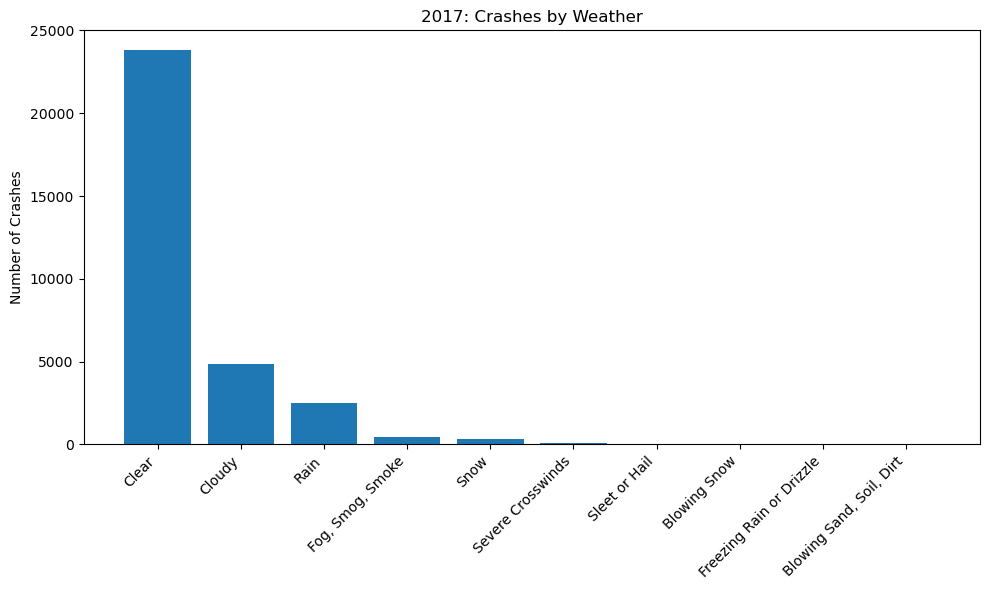

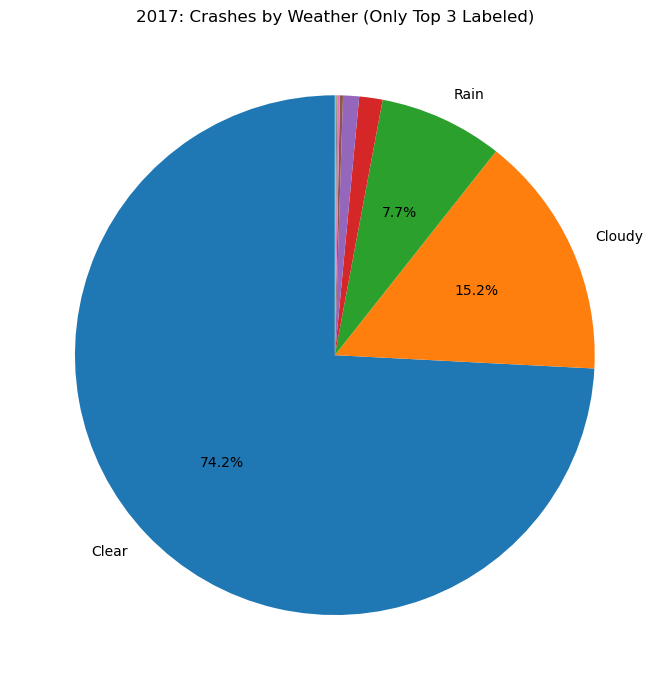

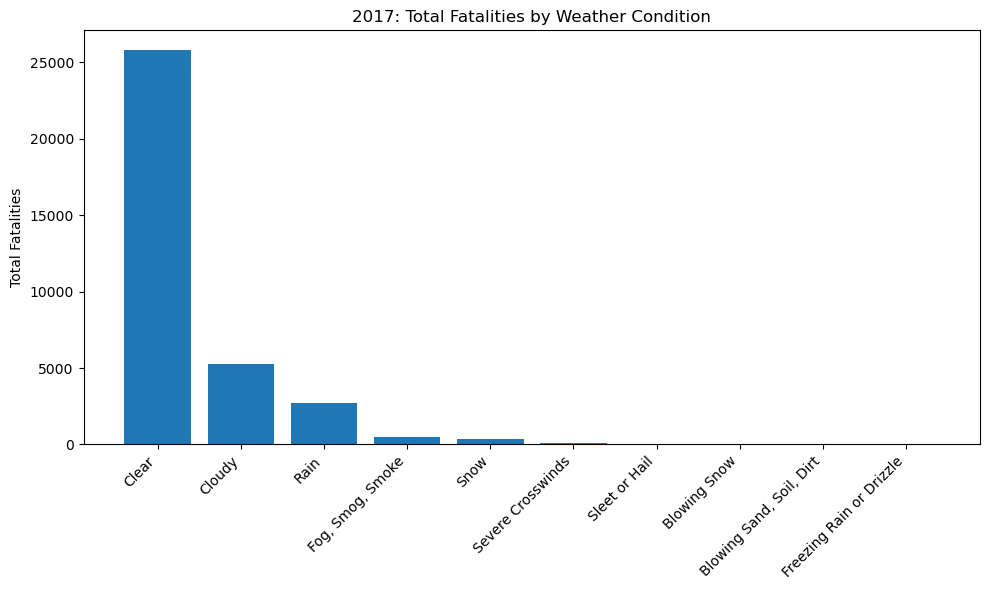

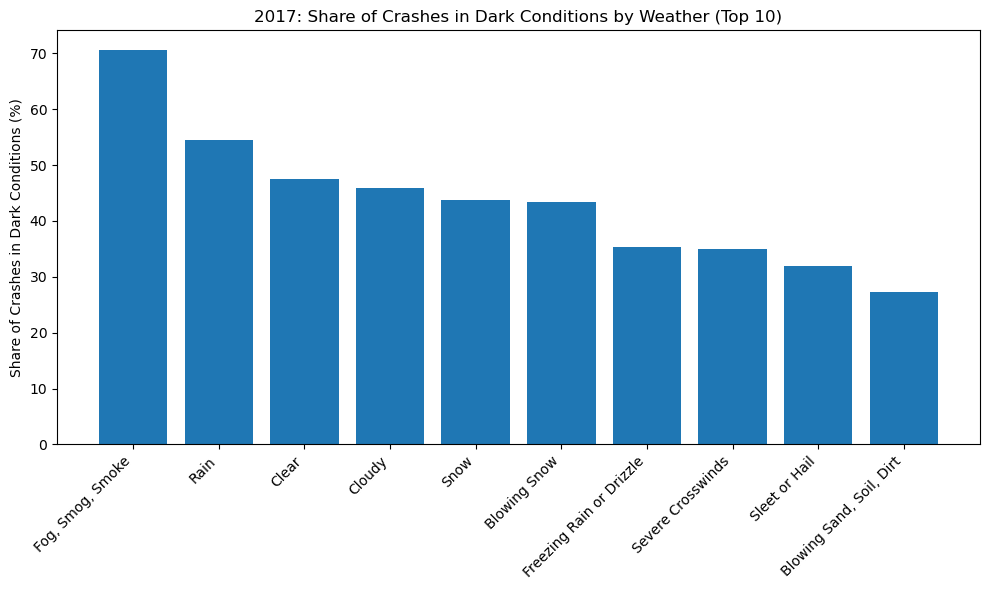

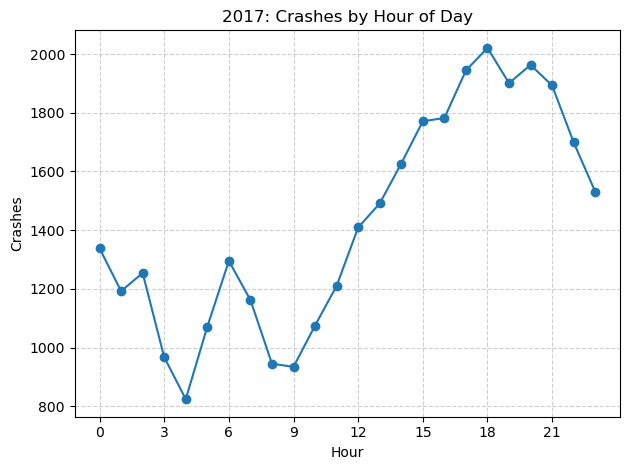

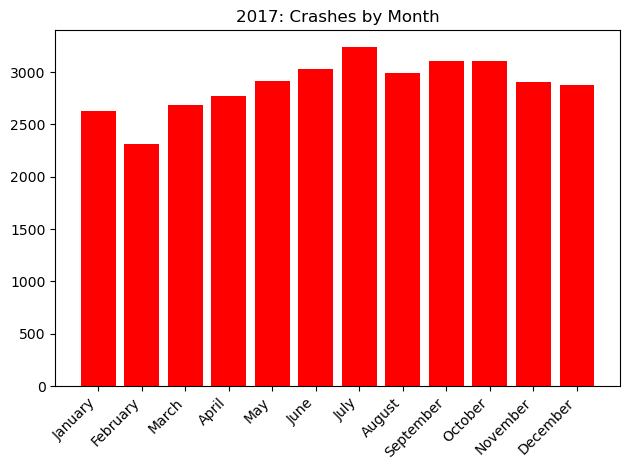

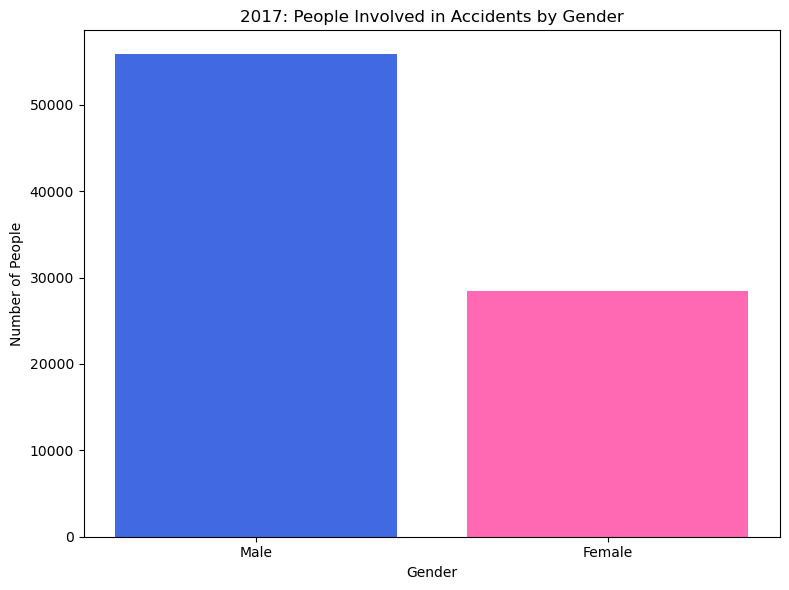

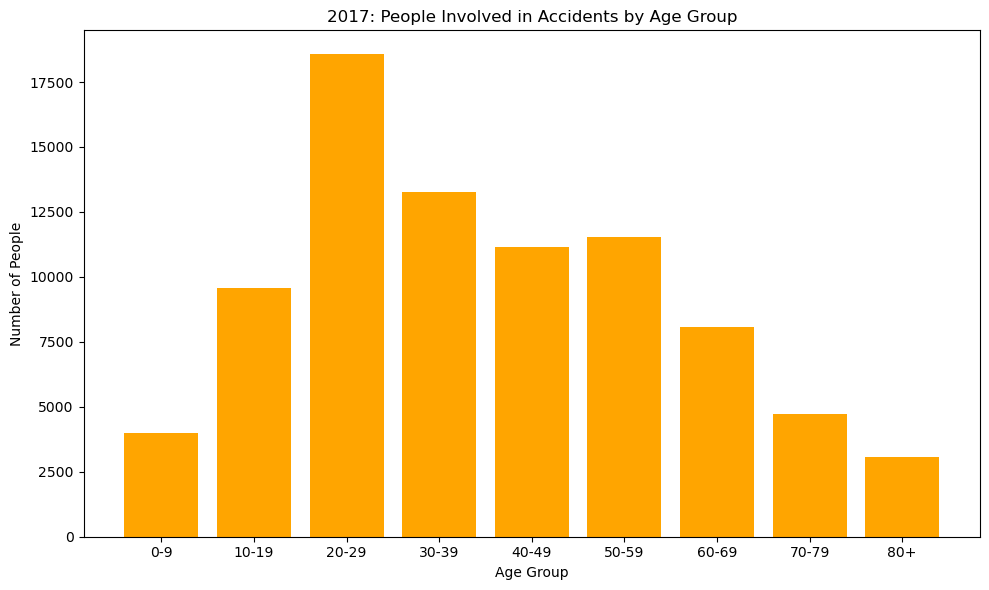

[Year 2017] Total crashes (cleaned): 32,106
  - Most common weather: Clear (23,817 crashes)
  - Highest fatalities weather: Clear (25,814 fatalities)
  - Peak crash hour: 18:00
  - Peak crash month: July
  - Gender distribution top: Male (55,823)
  - Peak age group: 20-29

[>] Running EDA for 2018


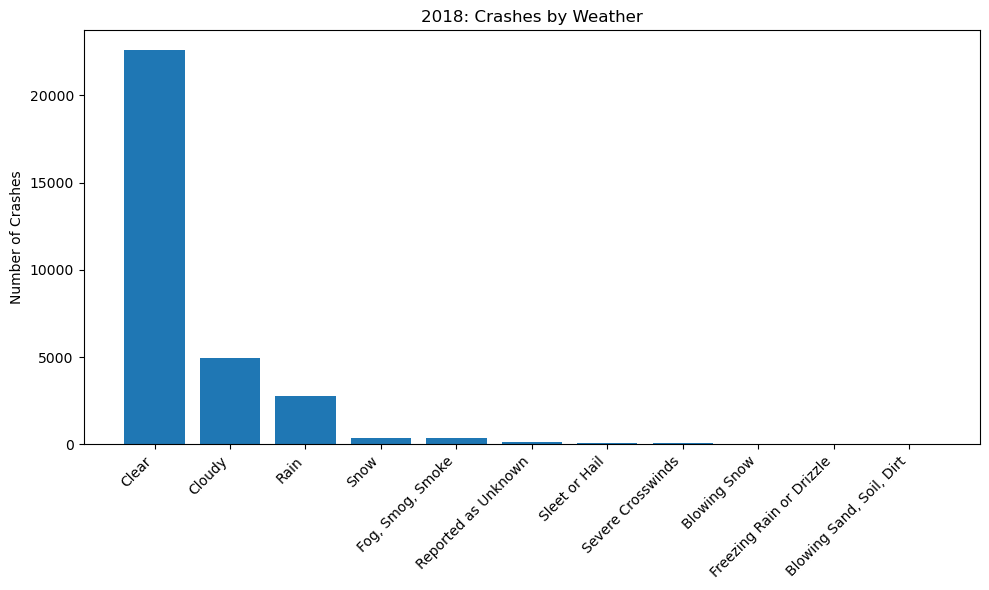

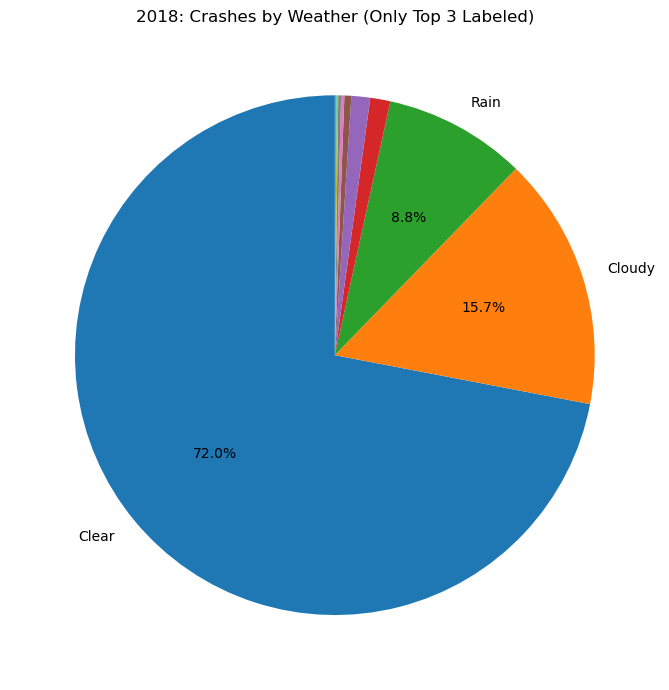

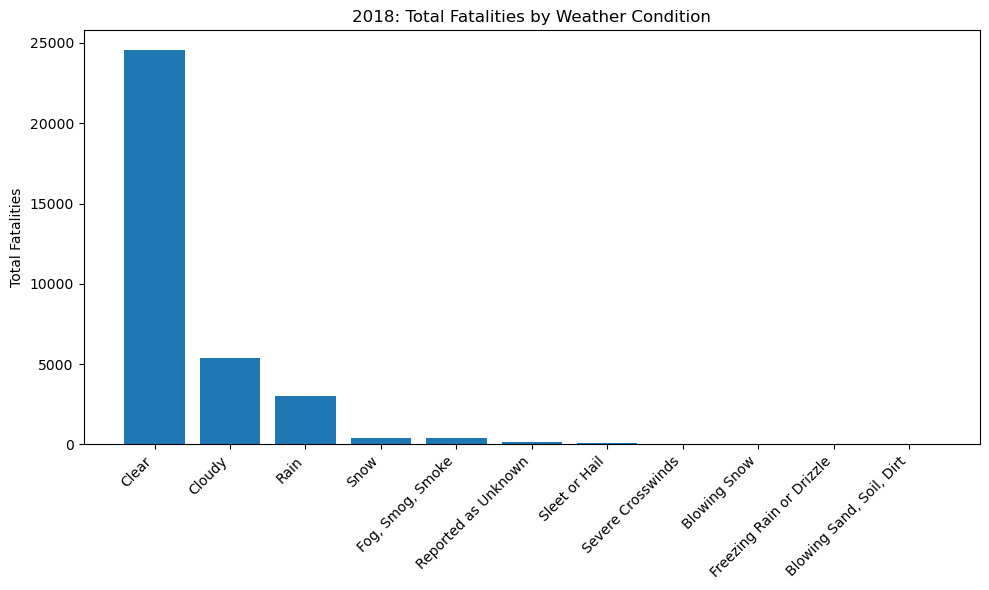

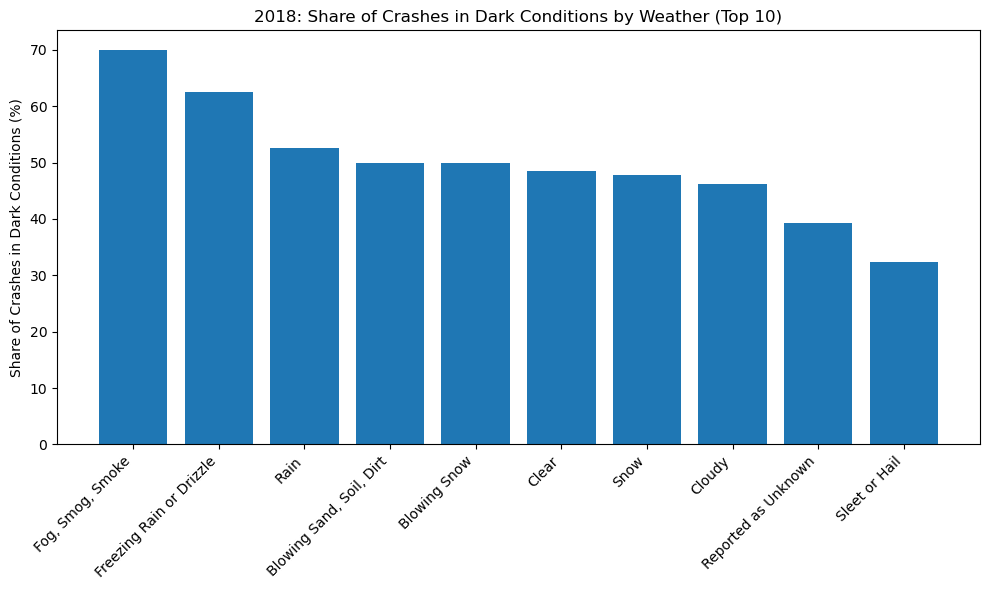

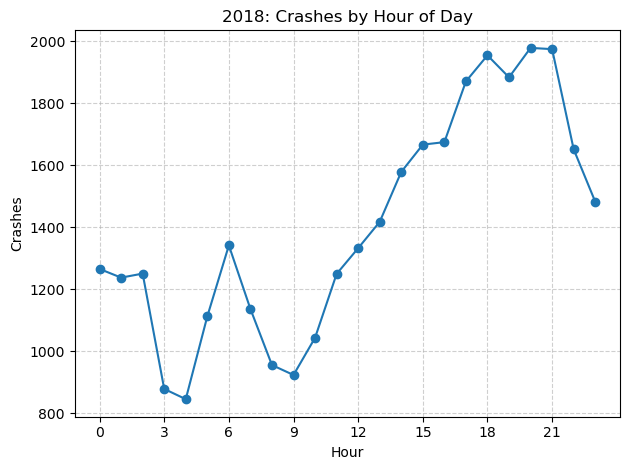

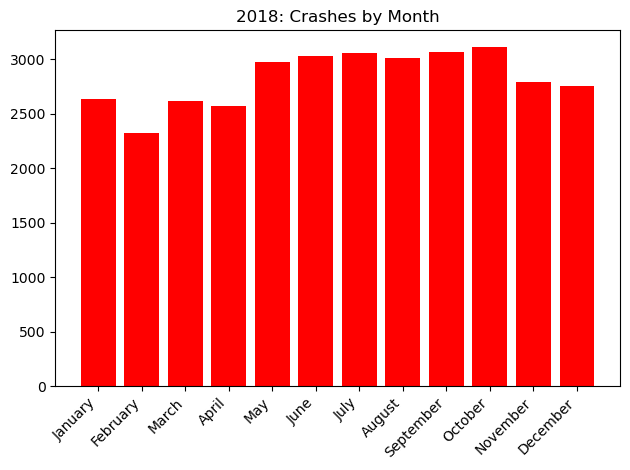

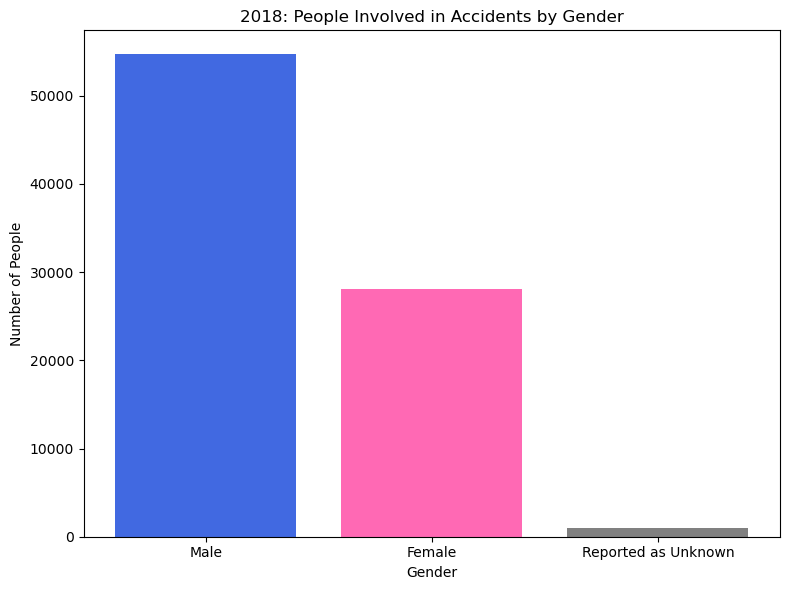

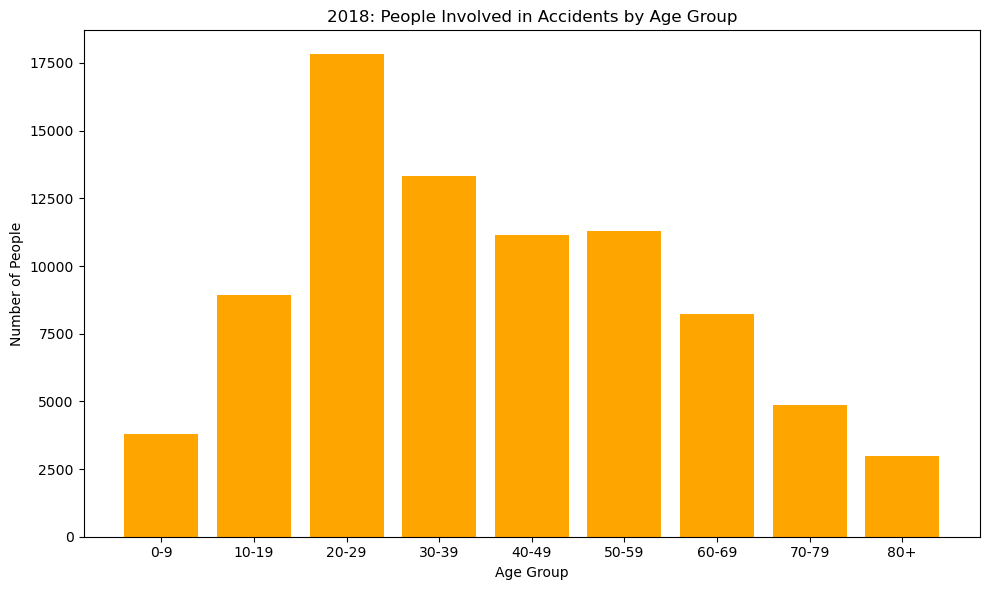

[Year 2018] Total crashes (cleaned): 31,389
  - Most common weather: Clear (22,595 crashes)
  - Highest fatalities weather: Clear (24,558 fatalities)
  - Peak crash hour: 20:00
  - Peak crash month: October
  - Gender distribution top: Male (54,684)
  - Peak age group: 20-29

Done.


In [11]:

summaries = []
for y in YEARS:
    d = load_year(y)
    if d is None:
        continue
    print(f"\n[>] Running EDA for {y}")
    s1 = eda_weather_time(d, y)
    s2 = eda_person(d, y)

    print(f"[Year {y}] Total crashes (cleaned): {s1['total_crashes']:,}")
    if s1["top_weather"]:
        topw = s1["top_weather"][0]
        print(f"  - Most common weather: {topw['WEATHERNAME']} ({topw['crashes']:,} crashes)")
    if s1["top_fatal_weather"]:
        topfw = s1["top_fatal_weather"][0]
        print(f"  - Highest fatalities weather: {topfw['WEATHERNAME']} ({topfw['total_fatalities']:,} fatalities)")
    if s1["peak_hour"] is not None:
        print(f"  - Peak crash hour: {s1['peak_hour']}:00")
    if s1["peak_month"] is not None:
        print(f"  - Peak crash month: {s1['peak_month']}")
    if s2["gender_top"]:
        print(f"  - Gender distribution top: {s2['gender_top'][0]['SEXNAME']} ({int(s2['gender_top'][0]['people_involved']):,})")
    if s2["age_peak"]:
        print(f"  - Peak age group: {s2['age_peak']}")

    summaries.append((s1, s2))

print("\nDone.")



## Interpretation Notes

**Weather:** The majority of fatal crashes often occur under **clear weather** simply because clear conditions are most common. However, even though clear weather is the most common condition, we can see that some weather types - such as rain, fog, or snow - still have a significant impact on the number of fatalities.

**Dark-share:** A higher **share of dark crashes** within certain weather types (e.g., fog/rain) suggests that **visibility** is also a very important factor.

**Time:** Hourly patterns clearly show how the **evening rush hours (16:00–20:00)** lead to a noticeable increase in the number of accidents, while the monthly analysis didn’t provide strong insights, as it’s difficult to draw clear conclusions from the data or visualizations.

**Demographics:** Gender is usually skewed toward **male involvement** in car accidents, which may be explained by higher exposure - men tend to drive more frequently, often for longer distances or at higher speeds, and are statistically more likely to engage in riskier driving behaviors such as speeding or driving under the influence.
The age distribution often peaks in the **20–29 or 30–39** groups, likely because these age ranges correspond to more active driving years - people in these groups typically commute daily, travel more, and may also be less risk-averse, leading to a higher involvement in accidents.


## Summary & Questions Answered

In [13]:

from IPython.display import Markdown, display

lines = []
for s1, s2 in summaries:
    y = s1["year"]
    lines.append(f"### {y}")
    lines.append(f"- Total crashes (cleaned): **{s1['total_crashes']:,}**")
    if s1["top_weather"]:
        tw = s1["top_weather"][0]
        lines.append(f"- Most common weather: **{tw['WEATHERNAME']}** ({tw['crashes']:,} crashes)")
    if s1["top_fatal_weather"]:
        tfw = s1["top_fatal_weather"][0]
        lines.append(f"- Weather with highest fatalities: **{tfw['WEATHERNAME']}** ({tfw['total_fatalities']:,})")
    if s1["peak_hour"] is not None:
        lines.append(f"- Peak crash hour: **{s1['peak_hour']}:00**")
    if s1["peak_month"] is not None:
        lines.append(f"- Peak crash month: **{s1['peak_month']}**")
    if s2["gender_top"]:
        gtop = s2["gender_top"][0]
        lines.append(f"- Gender most involved: **{gtop['SEXNAME']}** ({int(gtop['people_involved']):,})")
    if s2["age_peak"]:
        lines.append(f"- Peak age group: **{s2['age_peak']}**")
    lines.append("")

report = "\n".join(lines) if lines else "_No results available._"
display(Markdown(report))

print("\nQuestions answered:")
print("- Which weather conditions have the most crashes?")
print("- Which weather conditions are associated with the most fatalities?")
print("- How do crashes distribute by hour and by month?")
print("- What share of crashes in each weather type happen in the dark?")
print("- Which genders and age groups are most involved in fatal crashes?")


### 2015
- Total crashes (cleaned): **32,174**
- Most common weather: **Clear** (23,243 crashes)
- Weather with highest fatalities: **Clear** (25,337)
- Peak crash hour: **18:00**
- Peak crash month: **October**
- Gender most involved: **Male** (53,199)
- Peak age group: **20-29**

### 2016
- Total crashes (cleaned): **32,997**
- Most common weather: **Clear** (24,956 crashes)
- Weather with highest fatalities: **Clear** (27,122)
- Peak crash hour: **18:00**
- Peak crash month: **October**
- Gender most involved: **Male** (56,219)
- Peak age group: **20-29**

### 2017
- Total crashes (cleaned): **32,106**
- Most common weather: **Clear** (23,817 crashes)
- Weather with highest fatalities: **Clear** (25,814)
- Peak crash hour: **18:00**
- Peak crash month: **July**
- Gender most involved: **Male** (55,823)
- Peak age group: **20-29**

### 2018
- Total crashes (cleaned): **31,389**
- Most common weather: **Clear** (22,595 crashes)
- Weather with highest fatalities: **Clear** (24,558)
- Peak crash hour: **20:00**
- Peak crash month: **October**
- Gender most involved: **Male** (54,684)
- Peak age group: **20-29**



Questions answered:
- Which weather conditions have the most crashes?
- Which weather conditions are associated with the most fatalities?
- How do crashes distribute by hour and by month?
- What share of crashes in each weather type happen in the dark?
- Which genders and age groups are most involved in fatal crashes?


In [15]:
import requests
import pandas as pd

# Fetch 2022 county-level population data (ACS 5-year)
url = "https://api.census.gov/data/2022/acs/acs5?get=NAME,B01003_001E&for=county:*"

try:
    response = requests.get(url, timeout=10)
    response.raise_for_status()  # Raises an error if status != 200

    data = response.json()
    df = pd.DataFrame(data[1:], columns=data[0])
    df.rename(columns={"B01003_001E": "population"}, inplace=True)
    df["population"] = pd.to_numeric(df["population"])
    df["FIPS"] = df["state"] + df["county"]  # 5-digit FIPS code

    print("✅ Successfully fetched data for", len(df), "counties")
    print(df.head())

except Exception as e:
    print("❌ Error:", e)

❌ Error: HTTPSConnectionPool(host='api.census.gov', port=443): Max retries exceeded with url: /data/2022/acs/acs5?get=NAME,B01003_001E&for=county:* (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x12195ef60>: Failed to resolve 'api.census.gov' (Name or service not known: api.census.gov using 1 resolver(s))"))
